In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime

2024-11-30 18:57:14.558735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 18:57:14.568576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732989434.580350  403321 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732989434.583973  403321 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 18:57:14.595901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load pre-trained EfficientNetB0 without the top layers
#base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load pre-trained MobileNetV2 without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for digit classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Add dropout to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # For digits 0-9

I0000 00:00:1732989435.697984  403321 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
# Build the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [4]:
path_to_dataset = '/home/jc/KLIT/mydigits_dataset'

# Prepare the data
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    path_to_dataset,  # Folder with subfolders 0-9
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    path_to_dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4256 images belonging to 4 classes.
Found 1061 images belonging to 4 classes.


In [5]:
# TensorBoard setup
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [6]:
epochs = 10
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,  # Adjust based on your dataset size
    callbacks=[tensorboard_callback] 
)

# Save the model
model.save('imagenet_digit_classifier.keras')

/home/jc/KLIT/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1732989439.752355  403418 service.cc:148] XLA service 0x7cb3300021e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732989439.752382  403418 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-30 18:57:19.811578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732989440.179080  403418 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/133 ━━━━━━━━━━━━━━━━━━━━ 14:34 7s/step - accuracy: 0.1875 - loss: 1.9964

I0000 00:00:1732989444.041213  403418 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8899 - loss: 0.2829

2024-11-30 18:57:51.532975: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 16 bytes spill stores, 16 bytes spill loads

2024-11-30 18:57:51.595867: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181_0', 112 bytes spill stores, 144 bytes spill loads

2024-11-30 18:57:51.730475: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 228 bytes spill stores, 228 bytes spill loads



133/133 ━━━━━━━━━━━━━━━━━━━━ 45s 288ms/step - accuracy: 0.8905 - loss: 0.2814 - val_accuracy: 0.9859 - val_loss: 0.0226
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 249ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9849 - val_loss: 0.0275
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9849 - val_loss: 0.0300
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 1.0000 - loss: 9.0684e-04 - val_accuracy: 0.9868 - val_loss: 0.0250
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 249ms/step - accuracy: 1.0000 - loss: 5.1147e-04 - val_accuracy: 0.9877 - val_loss: 0.0200
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 1.0000 - loss: 4.3686e-04 - val_accuracy: 0.9840 - val_loss: 0.0317
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9877 - val_loss: 0.0228
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 34s 253ms/step - accuracy: 1.0000 - loss: 

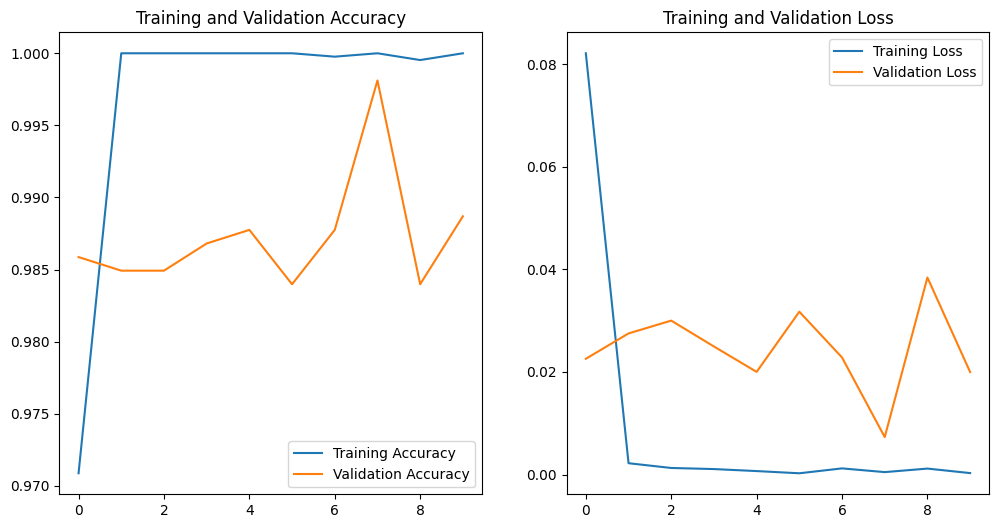

In [7]:
 import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [10]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

img_height, img_width = 224,224

# Load your trained model
model = load_model("imagenet_digit_classifier.keras")


# Class labels corresponding to digits 1, 2, 3, and 4
class_labels = [1, 2, 3, 4]

# Function to preprocess the image before feeding into the model
def preprocess_frame(frame):
    # Convert the frame to grayscale
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Resize the frame to img_heightximg_width pixels
    resized = cv2.resize(frame, (img_height, img_width))
    
    # Normalize the image (as your training data would have been normalized)
    normalized = resized / 255.0
    
    # Reshape to match the input shape of your model (batch_size, height, width, channels)
    reshaped = normalized.reshape(1, img_height, img_width, 3)
    
    return reshaped


# Initialize camera capture
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame from the camera
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to capture frame")
        break

    # Preprocess the frame for the model
    processed_frame = preprocess_frame(frame)
    
    # Perform inference
    predictions = model.predict(processed_frame, verbose=0)
    
    # Get the probabilities for digits 1, 2, 3, 4
    probabilities = predictions[0]  # Assuming your model outputs probabilities for 4 classes

    # Find the index of the highest probability
    max_index = np.argmax(probabilities)
    
    # Display the probabilities on the frame
    for i, prob in enumerate(probabilities):
        text = f"Digit {class_labels[i]}: {prob:.2f}"
        
        # Set text color: green for the highest probability, blue for others
        if i == max_index:
            color = (0, 255, 0)  # Green
        else:
            color = (255, 0, 0)  # Blue
            
        cv2.putText(frame, text, (10, 30 + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Show the frame with probabilities
    cv2.imshow('Digit Prediction', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture and close windows
cap.release()
cv2.destroyAllWindows()
